**Latent class analysis (LCA)**

**Imports:**

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import ace_tools_open as tools
from sklearn.manifold import TSNE

*Downloaing the dataset:*

In [14]:
df = pd.read_excel("sofiia_diploma_flights_final.xlsx")
df = df.drop(columns=['ID', 'ICAO Departure Airport', 'ICAO Arrival Airport', 'Currency', 'Aircraft'])

df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df = df.drop(columns=['Date'])
print(df.head())

   Route  Net Price  Gross Price  Profit         Departure City  \
0  there      38955        40876    1921                 Warsaw   
1   back      38955        40876    1921                   Sion   
2  there      39941        40755     814      London (Northolt)   
3   back      39941        40755     814                 Geneva   
4  there      64197        65362    1165  Dubai (World Central)   

        Arrival City  Num of Pax     Aircraft Type  Distance Trip Type  Month  \
0               Sion           4           Midsize   1198.21  Business      5   
1             Warsaw           4           Midsize   1198.21  Business      5   
2             Geneva           2             Light    762.27  Business      2   
3  London (Northolt)           2             Light    762.27  Business      2   
4             Jeddah           3  Ultra Long Range   1677.18  Business      6   

   DayOfWeek  
0          6  
1          4  
2          3  
3          2  
4          2  


*Transformation of categorical features and data scaling*

In [15]:
regions = {
    "asia": ['Hanoi', 'Tashkent', 'Almaty', 'Dushanbe', 'Yerevan', 'Addis Ababa', 'Dharavandhoo', 'Ganja'],
    "middle_east": ['Ercan', 'Riyadh', 'Jeddah', 'Dubai (World Central)'],
    "south_europe": ['Ponta Delgada', 'Cascais', 'Lisbon', 'Málaga', 'Alicante', 'Valencia', 'Ibiza', 'Palma de Mallorca', 
                     'Barcelona', 'Olbia', 'Rome (Ciampino)', 'Naples', 'Catania', 'Malta', 'Corfu', 'Thessaloniki', 
                     'Mykonos', 'Athens', 'Bodrum', 'Istanbul (Istanbul Airport)', 'Istanbul (Atatürk)', 'Dalaman', 
                     'Antalya', 'Gazipaşa', 'Paphos', 'Larnaca'],
    "east_europe": ['Warsaw', 'Kraków', 'Rzeszów', 'Košice', 'Suceava', 'Chișinău', 'Belgrade', 'Bucharest (Henri Coandă)', 
                    'Bucharest (Băneasa)', 'Sofia'],
    "north_europe": ['Reykjavik', 'Oslo', 'Tallinn', 'Riga', 'Copenhagen'],
    "center_europe": ['Berlin', 'Karlovy Vary', 'Prague', 'Munich', 'Vienna', 'Budapest', 'Innsbruck', 'Bolzano', 'Venice', 
                      'Florence', 'Tivat'],
    "west_europe": ['London (Northolt)', 'London (Biggin Hill)', 'London (Gatwick)', 'Amsterdam', 'Bremen', 'Liège', 
                    'Karlsruhe/Baden-Baden', 'Paris (Le Bourget)', 'Deauville', 'Zurich', 'Buochs', 'Sion', 'Geneva', 'Lugano', 
                    'Samedan', 'Chambéry', 'Courchevel Altiport', 'Courchevel', 'Milan (Malpensa)', 'Milan (Linate)', 'Genoa', 
                    'Monte Carlo', 'Nice', 'Cannes', 'Saint-Tropez', 'Toulon', 'Girona', 'Toulouse', 'San Sebastián'],
    "africa": ['Marrakesh'],
    "north_america": ['Carlsbad', 'San Francisco', 'Grand Cayman', 'Los Angeles', 'Toluca', 'Cancún', 'Sarasota', 'Van Nuys', 
                      'Page', 'Nassau']
}
city_mapping = {}

index = 0
for region, cities in regions.items():
    for city in cities:
        city_mapping[city] = index
        index += 1

def map_city(city):
    return city_mapping.get(city, -1)

df['Departure City'] = df['Departure City'].map(map_city)
df['Arrival City'] = df['Arrival City'].map(map_city)

aircraft_mapping = {
    "Turboprob": 0,
    "Entry Level": 1,
    "Light": 2,
    "Super Light": 3,
    "Midsize": 4,
    "Super Midsize": 5,
    "Heavy": 6,
    "Ultra Long Range": 7,
    "VIP Airliner": 8
}
df['Aircraft Type'] = df['Aircraft Type'].map(aircraft_mapping)
df['Trip Type'] = df['Trip Type'].map({'Business': 0, 'Vacation': 1})
df['Route'] = df['Route'].map({'there': 0, 'back': 1})

num_cols = ['Net Price', 'Gross Price', 'Profit', 'Distance']
descrete_cols = ['Aircraft Type', 'Trip Type', 'Route', 'Departure City', 'Arrival City', 'Num of Pax', 'Month', 'DayOfWeek']

scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler(feature_range=(-1, 1))

df_mixed = df.copy()
df_mixed[num_cols] = scaler_standard.fit_transform(df[num_cols])
df_mixed[descrete_cols] = scaler_minmax.fit_transform(df[descrete_cols])

print("Original data:")
print(df.head(), "\n")

print("Scaled data:")
print(df_mixed.head())


Original data:
   Route  Net Price  Gross Price  Profit  Departure City  Arrival City  \
0      0      38955        40876    1921              38            75   
1      1      38955        40876    1921              75            38   
2      0      39941        40755     814              64            76   
3      1      39941        40755     814              76            64   
4      0      64197        65362    1165              11            10   

   Num of Pax  Aircraft Type  Distance  Trip Type  Month  DayOfWeek  
0           4              4   1198.21          0      5          6  
1           4              4   1198.21          0      5          4  
2           2              2    762.27          0      2          3  
3           2              2    762.27          0      2          2  
4           3              7   1677.18          0      6          2   

Scaled data:
   Route  Net Price  Gross Price    Profit  Departure City  Arrival City  \
0   -1.0   0.059625     0.080

*Defining the class for LCA clustering:*

In [16]:
class LCACluster(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.model = None

    def fit(self, X, y=None):
        self.model = GaussianMixture(n_components=self.n_clusters, random_state=self.random_state)
        self.model.fit(X)
        return self

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.model.predict(X)

    def inertia_(self, X):
        return self.model.score(X) * X.shape[0]

Clustering Evaluation for Multiple Cluster Counts


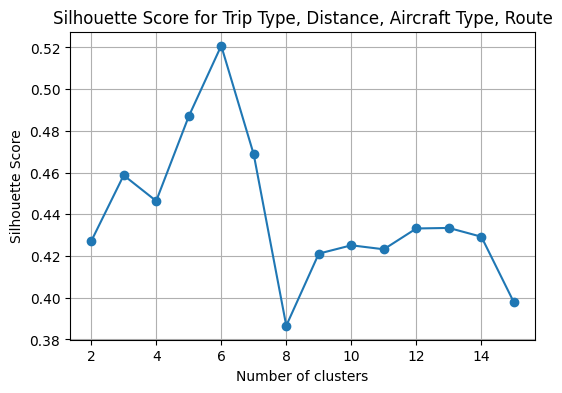

In [17]:
feature_sets = {
    "final": [ "Trip Type", "Distance", "Aircraft Type", "Route"]
}

def evaluate_clustering_multiple_clusters(features, cluster_range=(2, 15)):
    results = []
    X = df_mixed[features]

    for n_clusters in range(cluster_range[0], cluster_range[1] + 1):
        lca = LCACluster(n_clusters=n_clusters, random_state=42)
        labels = lca.fit_predict(X)

        sil_score = silhouette_score(X, labels)

        results.append({
            "Feature Set": ", ".join(features),
            "Num Clusters": n_clusters,
            "Silhouette Score": sil_score
        })

    return results

all_results = []
for name, features in feature_sets.items():
    all_results.extend(evaluate_clustering_multiple_clusters(features))

results_df = pd.DataFrame(all_results)
tools.display_dataframe_to_user(name="Clustering Evaluation for Multiple Cluster Counts", dataframe=results_df)

for feature_set in results_df["Feature Set"].unique():
    subset = results_df[results_df["Feature Set"] == feature_set]

    plt.figure(figsize=(6, 4))

    plt.plot(subset["Num Clusters"], subset["Silhouette Score"], marker='o', linestyle='-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.title(f"Silhouette Score for {feature_set}")
    plt.grid(True)

    plt.show()

*Using log-likelihood to choose the optimal number of clusters:*

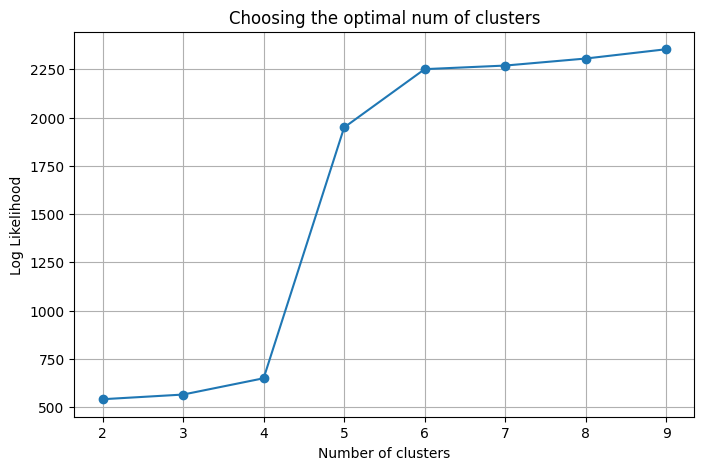

In [18]:
selected_features = ["Trip Type", "Distance", "Aircraft Type", "Route"]
X = df_mixed[selected_features]

inertia = []
cluster_range = range(2, 10)

for k in cluster_range:
    lca = LCACluster(n_clusters=k, random_state=42)
    lca.fit(X)
    inertia.append(lca.inertia_(X))

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of clusters')
plt.ylabel('Log Likelihood')
plt.title('Choosing the optimal num of clusters')
plt.grid()
plt.show()

*Clusters characteristics:*

In [19]:
optimal_k = 6
lca = LCACluster(n_clusters=optimal_k, random_state=42)
df_mixed["Cluster"] = lca.fit_predict(X)

cluster_summary = df_mixed.groupby("Cluster")[selected_features].agg(["min", "max", "mean", "median"])
cluster_counts = df_mixed["Cluster"].value_counts().sort_index()
cluster_summary["Count"] = cluster_counts

tools.display_dataframe_to_user(name="Cluster Characteristics", dataframe=cluster_summary)

Cluster Characteristics


*Visualization of clasters in 2D using t-SNE*

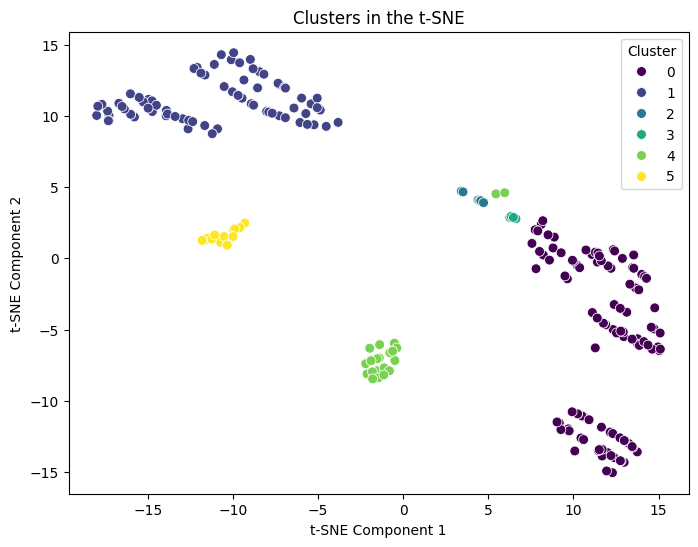

In [20]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

df_mixed["t-SNE_1"] = X_tsne[:, 0]
df_mixed["t-SNE_2"] = X_tsne[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_mixed["t-SNE_1"], y=df_mixed["t-SNE_2"], hue=df_mixed["Cluster"], palette="viridis", s=50)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Clusters in the t-SNE")
plt.legend(title="Cluster")
plt.show()

*Characteristics of financial features for each cluster:*

In [21]:
financial_features = ["Net Price", "Gross Price", "Profit"]
cluster_financial_summary = df_mixed.groupby("Cluster")[financial_features].agg(["min", "max", "mean", "median"])

tools.display_dataframe_to_user(name="Cluster Financial Characteristics", dataframe=cluster_financial_summary)

Cluster Financial Characteristics


*Visualization of financial features for each cluster:*

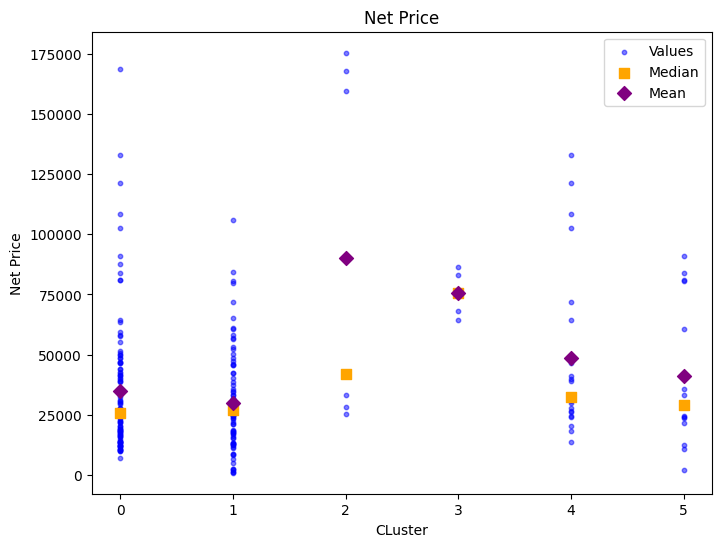

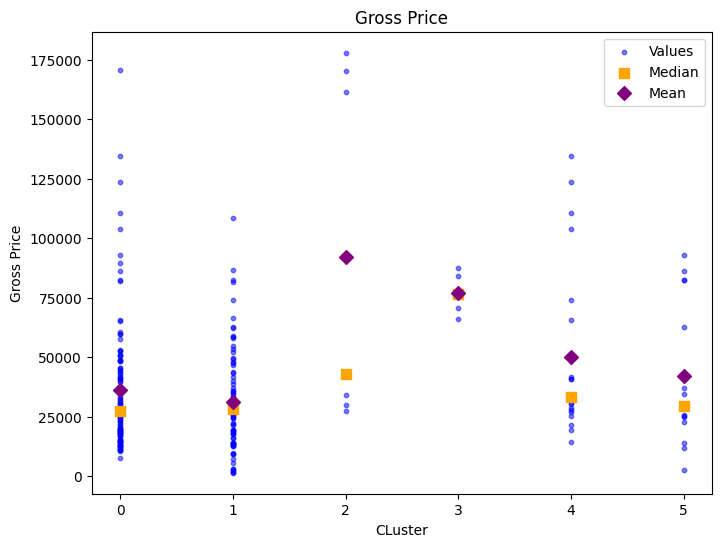

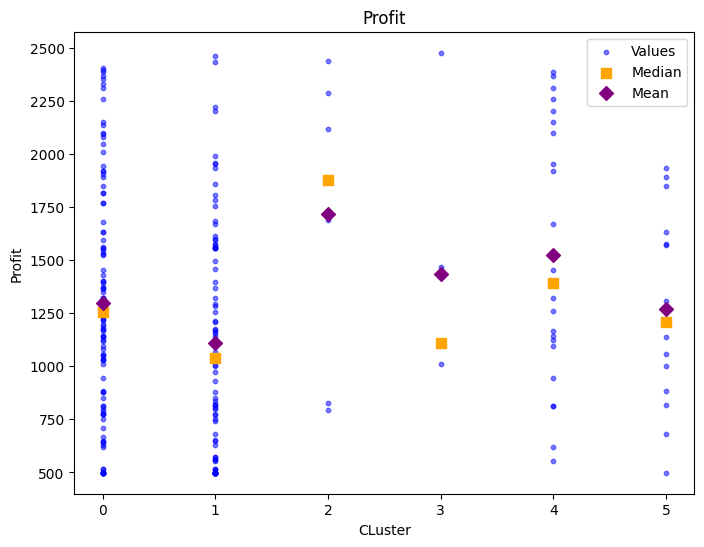

In [22]:
financial_means = {
    "Net Price": 37156.582329,
    "Gross Price": 38420.887550,
    "Profit": 1264.305221
}

financial_stds = {
    "Net Price": 30223.025387,
    "Gross Price": 30525.547796,
    "Profit": 549.716403
}

#X = X0 * st.d. + mean
df_unscaled = df_mixed.copy()
for feature in financial_features:
    df_unscaled[feature] = df_mixed[feature] * financial_stds[feature] + financial_means[feature]

cluster_financial_stats = df_unscaled.groupby("Cluster")[financial_features].agg(["min", "max", "median", "mean"])


for feature in financial_features:
    plt.figure(figsize=(8, 6))
    clusters = df_unscaled["Cluster"].unique()

    for cluster in clusters:
        cluster_values = df_unscaled[df_unscaled["Cluster"] == cluster][feature]
        plt.scatter([cluster] * len(cluster_values), cluster_values, color='blue', alpha=0.5, s=10, label="Values" if cluster == 0 else "")

    medians = cluster_financial_stats[(feature, "median")]
    means = cluster_financial_stats[(feature, "mean")]

    for cluster in clusters:
        plt.scatter(cluster, medians[cluster], color='orange', marker='s', s=50, label='Median' if cluster == 0 else "")
        plt.scatter(cluster, means[cluster], color='purple', marker='D', s=50, label='Mean' if cluster == 0 else "")

    plt.title(f"{feature}")
    plt.xlabel("CLuster")
    plt.ylabel(feature)
    plt.legend()
    plt.show()
